In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy import signal
from qutip.operators import destroy,create


In [48]:
hbar = 1.054571e-34 # J*s
pi = np.pi
phi_0 = 2.06783384e-15 # Wb (or V*s)

# Parameters from the Paper
# Inductances (in H)
Lc = 10e-9
Lf = 10e-9
L1 =  10e-9
L2 =  10e-9
L3 =  10e-9
L4 =  10e-9

# Inductor Loop inductances
Ln0 = 1e-9
Ln1 =  10e-9
Ln2 =  10e-9
Ln3 =  10e-9
Ln4 =  10e-9
Ln5 = 2e-9
L_tot = Ln0 + Ln1 + Ln2 + Ln3 + Ln4 + Ln5

# Mutual Inducctances (in H)
Mc = 8e-9
Mf = 0.8e-9

# Due to Matching Conditions
M1 = 8e-9
M2 = 8e-9
M3 = 0.8e-9
M4 =0.8e-9
M12 = 7.023e-9
M34  = 7.023e-9
# Mutual Inductance between QET and first SQUID loop
M = 0.02e-9 # Henries 


# Coupling Coefficients
K_c = Mc / Lc
K_f = Mf / Lf
K12 = M12/Lc
K34 = M34/Lf

# Parameters from Paper:

#Josephson Energies (for qubit 1):
EJ1 = hbar * 2 * pi * 11.147e9
EJ2 = hbar * 2 * pi * 11.147e9
EJ = hbar * 2 * pi * 11.147e9
#Charging Energy for Transmon (for qubit 1):
Ec = hbar * 2 * pi * 148.628e6 

# Operators 
a = destroy(2)
a_dag = create(2)

In [49]:
F = (Lc*Lf) *((-L_tot*Lf+Mf**2)*Lc+Lf*Mc**2)+(Lf+M34)*(L_tot*Lf-L_tot*M34-2*Mf**2)*M12**2 +(2*(Lf**2)*(Mc**2)-2*(M34**2)*(Mc**2))*M12+ Lc*((L_tot*Lc-2*Mc**2)*(M34**2)+2*Lc*Mf*Mf*M34+Lc*Lf*Mf**2 + (Lf**2)*(Mc**2))

In [50]:
# Possibly Needed Functions

# Current through inductor Loop:
def i_p_loop(phi_A, phi_B, phi_C, phi_D):
    ''' 
    Computes current through inductor loop determined by Eq. 1
    INPUT:
    phi_(A/B/C/D): SFQ flux pulse (time integral of voltage at input A/B/C/D) in (Wb)
    OUTPUT:
    current through loop (in A)
    '''
    return (1/F) * ((phi_A -phi_B)*(Lf**2-M34**2)*(Lc+M12)*Mc+(phi_C-phi_D)*(Lc**2-M12**2)*(Lf+M34)*Mf)



def n(phi_in,phi_out): # Equations 3 and 4
    return ((phi_in - phi_out) / phi_0)

# Equations 5 and 6
def r(tuning = 'COARSE'):
    if tuning == 'COARSE':
       return (M/F) * (Lf**2 -M34**2)*(Lc + M12)*Mc
    else:
        return (M/F) * (Lc**2 -M12**2)*(Lf + M34)*Mf
    

# Currents from equations 7 and 8
def d_ip_tuned(tuning = 'COARSE'):
    ''' returns current in amperes'''
    if tuning == 'COARSE':
        return (1/F) *( Lf**2-M34**2)*(Lc+M12)*Mc*phi_0
    else:
        return (1/F) * (Lc**2 - M12**2)*(Lf+M34)*Mf*phi_0

def Phi_ext_current(di): # Equations 9 and 10 and 29
    ''' 
    compute the external flux through squid (use for both FINE and COARSE tuning)
    INPUT:
    di (Amperes): change in current
    '''
    return M*di 

# Equations 13 and 14
def Phi_ext_tuned(tuning = 'COARSE'):
    return r(tuning)* phi_0

# Equation 11
def i_p_quantized(phi_A, phi_B, phi_C, phi_D): 
    n_c = n(phi_A,phi_B)
    n_f = n(phi_C,phi_D)
   # print(n_c)
   # print(n_f)
    d_ipc = d_ip_tuned("COARSE")
    #print(d_ipc)
    d_ipf = d_ip_tuned("FINE")
    #print(d_ipf)
    return n_c * d_ipc + n_f * d_ipf

# Equation 12
def Phi_ext_flux(phi_A, phi_B, phi_C, phi_D):
    n_c = n(phi_A,phi_B)
    n_f = n(phi_C,phi_D)
    Phi_ec = M * d_ip_tuned("COARSE")
    Phi_ef = M * d_ip_tuned("FINE")
    return n_c * Phi_ec + n_f * Phi_ef

def plot_current(t,phiA,phiB,phiC,phiD,ploting=True):
    ip = np.zeros(len(t))
    for ii in range(len(t)):
        if phiA[ii] != 0 or phiB[ii] != 0 or phiC[ii] != 0 or phiD[ii] != 0:
            ip[ii:-1]+=i_p_quantized(phiA[ii], phiB[ii], phiC[ii], phiD[ii])
        #if phiB[ii] != 0:
        #    ip[ii:-1]+=i_p_quantized(phiA[ii], phiB[ii], phiC[ii], phiD[ii])
        #if phiC[ii] != 0:
        #    ip[ii:-1]+=i_p_quantized(phiA[ii], phiB[ii], phiC[ii], phiD[ii])
        #if phiD[ii] != 0:
        #    ip[ii:-1]+=i_p_quantized(phiA[ii], phiB[ii], phiC[ii], phiD[ii])
    if ploting:
        plt.plot(t,ip*1e6)
    return ip # in Amperes

# Total Josephson Coupling Energy
def E_Jsigma (EJ1, EJ2):
    return EJ1 + EJ2

def reduced_flux(phi):
    return pi * phi / phi_0
# Effective Josephson Energy of SQUID
def E_JS(EJ1, EJ2,x, flux = True):
    d = (EJ2 - EJ1)/E_Jsigma(EJ1,EJ2)
    if flux:
        return E_Jsigma(EJ1,EJ2) *np.abs(np.cos(x)) * np.sqrt(1+(d**2)*(np.tan(x)**2))
    else:
        return E_Jsigma(EJ1,EJ2) *np.abs(np.cos(pi * M * x/ phi_0)) * np.sqrt(1+(d**2)*(np.tan(pi * M * x /phi_0)**2))
    
def ground(Ec,EJ1, EJ2,x, flux = True):
    EJ = E_JS(EJ1, EJ2,x, flux)
    return -Ec/4 - EJ

def first_excited(Ec,EJ1,EJ2,x,flux = True):
    EJ = E_JS(EJ1, EJ2,x, flux)
    return np.sqrt(8*Ec*EJ) -Ec - Ec/4 - EJ

def second_excited(Ec,EJ1,EJ2,x,flux = True):
    EJ = E_JS(EJ1, EJ2,x, flux)
    return  2 * np.sqrt(8*Ec*EJ) - 3*Ec -Ec/4  - EJ

def E10(E1,E0):
    return E1- E0

def E21(E2,E1):
    return E2-E1

def anharmonicity(E21,E10):
    return E21-E10

def qubit_freq(Ec, EJ1, EJ2,x, flux = False):
    EJ = E_JS(EJ1, EJ2,x, flux)
    return (np.sqrt(8 * Ec * EJ) - Ec)/ hbar

def d_omega_freq(w_work, w_idle):
    return w_work - w_idle

def d_omega_energy(Ec, EJ1, EJ2,x_work,x_idle, flux = False):
    EJ_work = E_JS(EJ1, EJ2,x_work, flux)
    EJ_idle = E_JS(EJ1, EJ2,x_idle, flux)
    return np.sqrt(8*Ec) * (np.sqrt(EJ_work)- np.sqrt(EJ_idle))

def qubit_ham(omega,alpha):
    return hbar*(omega* a_dag*a + (alpha/2)* a_dag*a_dag*a*a) 

def drive_ham_z(omega):
    return hbar * omega * a_dag * a

In [51]:
def process_file(input_file):
    with open(input_file, 'r') as file:
        lines = file.readlines()

    lines_with_numbers = [line for line in lines if line.strip().startswith(('0', '1', '2', '3', '4', '5', '6', '7', '8', '9'))]
    n = len(lines_with_numbers)
    x = np.zeros([int(n / 2), 7])

    for ii in range(len(lines_with_numbers)):
        temp = lines_with_numbers[ii].split()

        if ii == float(temp[0]):
            for jj in range(len(temp)):
                x[ii, jj] = float(temp[jj])

        else:
            idx = int(temp[0])
            x[idx, -1] = float(temp[-1])
            x[idx, -2] = float(temp[-2])

    t = x[:, 1]
    i_p = x[:, 2]
    v_a = x[:, 3]
    v_b = x[:, 4]
    v_c = x[:, 5]
    v_d = x[:, 6]

    return t, i_p, v_a, v_b, v_c, v_d


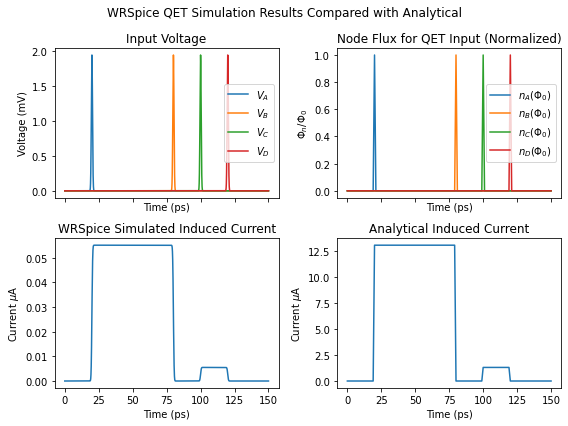

In [52]:
input_file = "C:\\Users\\malid\\qet_1"
t, i_p, v_a, v_b, v_c, v_d = process_file(input_file)

t_anal = np.linspace(0,150,151)
phi_a = np.zeros(len(t_anal)) ; phi_a[20] = phi_0
phi_b =np.zeros(len(t_anal)) ; phi_b[80] = phi_0
phi_c = np.zeros(len(t_anal)); phi_c[100] = phi_0
phi_d = np.zeros(len(t_anal)); phi_d[120] = phi_0
ip= plot_current(t_anal,phi_a,phi_b,phi_c,phi_d,ploting=False)
fig, axs = plt.subplots(2,2,figsize=(8, 6),sharex=True)
fig.suptitle('WRSpice QET Simulation Results Compared with Analytical')
axs[0,0].plot(t*1e12, v_a*1e3,label = r'$V_A$')
axs[0,0].plot(t*1e12, v_b*1e3,label = r'$V_B$')
axs[0,0].plot(t*1e12, v_c*1e3,label = r'$V_C$')
axs[0,0].plot(t*1e12, v_d*1e3,label = r'$V_D$')
axs[0,0].set_ylabel('Voltage (mV)')
axs[0,0].legend()
axs[0,0].set_xlabel('Time (ps)')
axs[0,1].set_xlabel('Time (ps)')
axs[1,0].set_xlabel('Time (ps)')
axs[1,1].set_xlabel('Time (ps)')
axs[0,0].set_title('Input Voltage')
axs[0,1].set_title('Node Flux for QET Input (Normalized)')
axs[0,1].plot(t_anal,phi_a/phi_0, label=r'$n_A(\Phi_0) $')
axs[0,1].plot(t_anal,phi_b/phi_0, label=r'$n_B(\Phi_0)$ ')
axs[0,1].plot(t_anal,phi_c/phi_0, label=r'$n_C(\Phi_0)$ ')
axs[0,1].plot(t_anal,phi_d/phi_0, label=r'$n_D(\Phi_0)$ ')
axs[0,1].set_ylabel(r'$\Phi_n/\Phi_0$')
axs[0,1].legend()
axs[1,0].plot(t*1e12, i_p*1e6, label = 'WRSpice')
axs[1,0].set_title('WRSpice Simulated Induced Current')
axs[1,0].set_ylabel(r'Current $\mu$A')
axs[1,1].plot(t_anal,ip*1e6, label = 'Analytical')
axs[1,1].set_title('Analytical Induced Current')
axs[1,1].set_ylabel(r'Current $\mu$A')
plt.tight_layout()

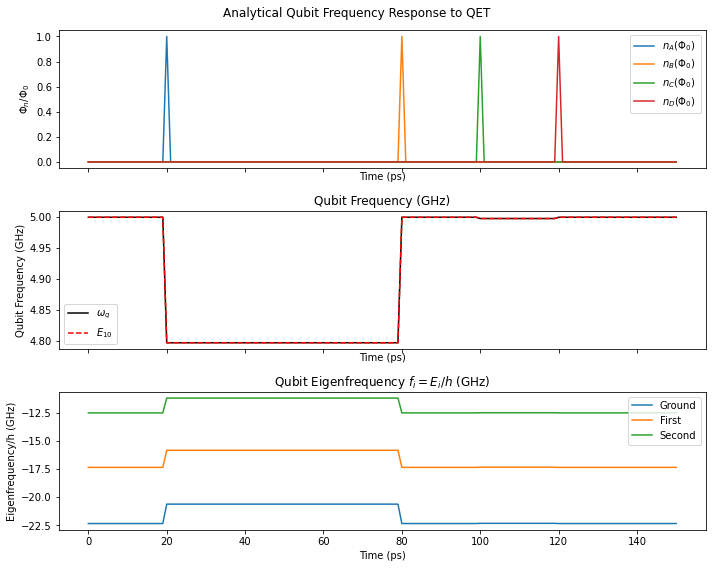

In [53]:
E0 = ground(Ec,EJ1, EJ2,ip, flux = False)
E1 = first_excited(Ec,EJ1,EJ2,ip,flux = False)
E2 = second_excited(Ec,EJ1,EJ2,ip,flux = False)
w_qb1 = qubit_freq(Ec, EJ1, EJ2,ip, flux = False)
fig, axs = plt.subplots(3,figsize=(10, 8),sharex=True)
axs[0].plot(t_anal,phi_a/phi_0, label=r'$n_A(\Phi_0) $')
axs[0].plot(t_anal,phi_b/phi_0, label=r'$n_B(\Phi_0)$ ')
axs[0].plot(t_anal,phi_c/phi_0, label=r'$n_C(\Phi_0)$ ')
axs[0].plot(t_anal,phi_d/phi_0, label=r'$n_D(\Phi_0)$ ')
axs[0].set_ylabel(r'$\Phi_n/\Phi_0$')
axs[0].set_xlabel('Time (ps)')
axs[1].set_xlabel('Time (ps)')
axs[2].set_xlabel('Time (ps)')
axs[0].legend()
axs[1].plot(t_anal,w_qb1/(2*pi)*1e-9 , c= 'k', label = r'$\omega_q$')
axs[1].set_title('Qubit Frequency (GHz)')
axs[1].set_xlabel('Time (ps)')
axs[1].set_ylabel('Qubit Frequency (GHz)')
axs[2].plot(t_anal,E0/(hbar * 2 * pi)*1e-9,label = 'Ground')
axs[2].plot(t_anal,E1/(hbar * 2 * pi)*1e-9,label ='First')
axs[2].plot(t_anal,E2/(hbar * 2 * pi)*1e-9, label = 'Second')
axs[2].set_title(r'Qubit Eigenfrequency $f_i = E_i /h$ (GHz)')
axs[2].legend()
axs[2].set_ylabel('Eigenfrequency/h (GHz)')
axs[1].plot(t_anal,E1/(hbar * 2 * pi)*1e-9-E0/(hbar * 2 * pi)*1e-9,'--',c= 'r',label = r'$E_{10}$')
axs[1].legend()
fig.suptitle('Analytical Qubit Frequency Response to QET')
plt.tight_layout()

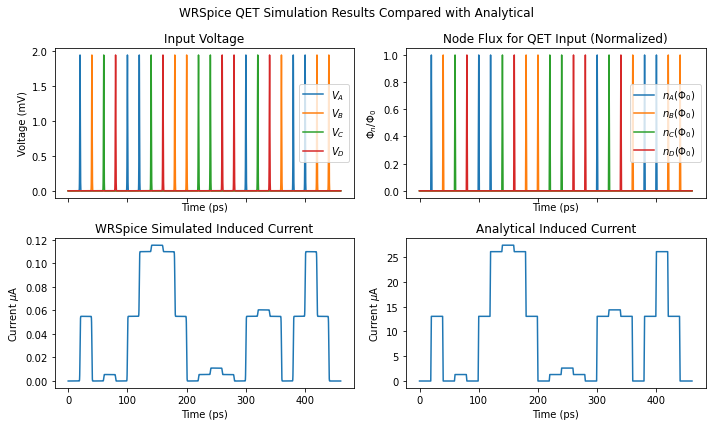

In [54]:
input_file = "C:\\Users\\malid\\qet_seq"
t, i_p, v_a, v_b, v_c, v_d = process_file(input_file)

t_anal = np.linspace(0,460,461)
phi_a = np.zeros(len(t_anal)) ; phi_a[20] = phi_0; phi_a[100] = phi_0; phi_a[120] = phi_0; phi_a[300] = phi_0 ;phi_a[380] = phi_0; phi_a[400] = phi_0
phi_b =np.zeros(len(t_anal)) ; phi_b[40] = phi_0;phi_b[180] = phi_0;phi_b[200] = phi_0;phi_b[360] = phi_0;phi_b[420] = phi_0;phi_b[440] = phi_0
phi_c = np.zeros(len(t_anal)); phi_c[60] = phi_0;phi_c[140] = phi_0;phi_c[220] = phi_0;phi_c[240] = phi_0;phi_c[320] = phi_0
phi_d = np.zeros(len(t_anal)); phi_d[80] = phi_0;phi_d[160] = phi_0;phi_d[260] = phi_0;phi_d[280] = phi_0;phi_d[340] = phi_0
ip= plot_current(t_anal,phi_a,phi_b,phi_c,phi_d,ploting=False)
fig, axs = plt.subplots(2,2,figsize=(10, 6),sharex=True)
fig.suptitle('WRSpice QET Simulation Results Compared with Analytical')
axs[0,0].plot(t*1e12, v_a*1e3,label = r'$V_A$')
axs[0,0].plot(t*1e12, v_b*1e3,label = r'$V_B$')
axs[0,0].plot(t*1e12, v_c*1e3,label = r'$V_C$')
axs[0,0].plot(t*1e12, v_d*1e3,label = r'$V_D$')
axs[0,0].set_ylabel('Voltage (mV)')
axs[0,0].legend()
axs[0,0].set_xlabel('Time (ps)')
axs[0,1].set_xlabel('Time (ps)')
axs[1,0].set_xlabel('Time (ps)')
axs[1,1].set_xlabel('Time (ps)')
axs[0,0].set_title('Input Voltage')
axs[0,1].set_title('Node Flux for QET Input (Normalized)')
axs[0,1].plot(t_anal,phi_a/phi_0, label=r'$n_A(\Phi_0) $')
axs[0,1].plot(t_anal,phi_b/phi_0, label=r'$n_B(\Phi_0)$ ')
axs[0,1].plot(t_anal,phi_c/phi_0, label=r'$n_C(\Phi_0)$ ')
axs[0,1].plot(t_anal,phi_d/phi_0, label=r'$n_D(\Phi_0)$ ')
axs[0,1].set_ylabel(r'$\Phi_n/\Phi_0$')
axs[0,1].legend()
axs[1,0].plot(t*1e12, i_p*1e6, label = 'WRSpice')
axs[1,0].set_title('WRSpice Simulated Induced Current')
axs[1,0].set_ylabel(r'Current $\mu$A')
axs[1,1].plot(t_anal,ip*1e6, label = 'Analytical')
axs[1,1].set_title('Analytical Induced Current')
axs[1,1].set_ylabel(r'Current $\mu$A')
plt.tight_layout()

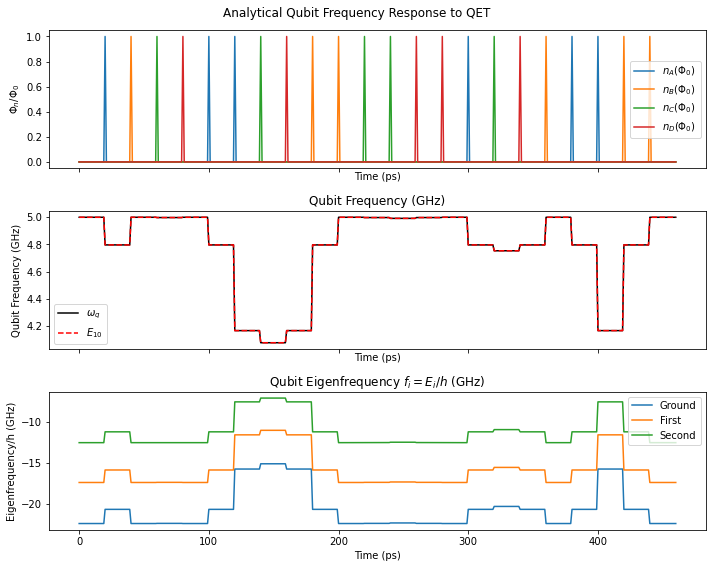

In [55]:
E0 = ground(Ec,EJ1, EJ2,ip, flux = False)
E1 = first_excited(Ec,EJ1,EJ2,ip,flux = False)
E2 = second_excited(Ec,EJ1,EJ2,ip,flux = False)
w_qb1 = qubit_freq(Ec, EJ1, EJ2,ip, flux = False)
fig, axs = plt.subplots(3,figsize=(10, 8),sharex=True)
axs[0].plot(t_anal,phi_a/phi_0, label=r'$n_A(\Phi_0) $')
axs[0].plot(t_anal,phi_b/phi_0, label=r'$n_B(\Phi_0)$ ')
axs[0].plot(t_anal,phi_c/phi_0, label=r'$n_C(\Phi_0)$ ')
axs[0].plot(t_anal,phi_d/phi_0, label=r'$n_D(\Phi_0)$ ')
axs[0].set_ylabel(r'$\Phi_n/\Phi_0$')
axs[0].set_xlabel('Time (ps)')
axs[1].set_xlabel('Time (ps)')
axs[2].set_xlabel('Time (ps)')
axs[0].legend()
axs[1].plot(t_anal,w_qb1/(2*pi)*1e-9 , c= 'k', label = r'$\omega_q$')
axs[1].set_title('Qubit Frequency (GHz)')
axs[1].set_xlabel('Time (ps)')
axs[1].set_ylabel('Qubit Frequency (GHz)')
axs[2].plot(t_anal,E0/(hbar * 2 * pi)*1e-9,label = 'Ground')
axs[2].plot(t_anal,E1/(hbar * 2 * pi)*1e-9,label ='First')
axs[2].plot(t_anal,E2/(hbar * 2 * pi)*1e-9, label = 'Second')
axs[2].set_title(r'Qubit Eigenfrequency $f_i = E_i /h$ (GHz)')
axs[2].legend()
axs[2].set_ylabel('Eigenfrequency/h (GHz)')
axs[1].plot(t_anal,E1/(hbar * 2 * pi)*1e-9-E0/(hbar * 2 * pi)*1e-9,'--',c= 'r',label = r'$E_{10}$')
axs[1].legend()
fig.suptitle('Analytical Qubit Frequency Response to QET')
plt.tight_layout()